In [ ]:

!pip install roboschool==1.0.48 gym==0.15.4

!pip install box2d-py

!pip install pybullet



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from matplotlib import pyplot as plt

import numpy as np

import gym


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def set_checkpoint(env_name,directory,run_num_pretrained, random_seed=0 ):
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)


    checkpoint_path = directory + \
        "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
    print("save checkpoint path : " + checkpoint_path)
    return checkpoint_path


In [ ]:
def plot_result(rewards: list) -> None:
      plt.title('Reward per episode')
      plt.plot(rewards)
      plt.xlabel('# Episodes')
      plt.ylabel('Rewards')
      plt.show()

In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [ ]:
class ActorCriticNN(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCriticNN, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full(
                (action_dim,), action_std_init * action_std_init).to(device)

        # Actor layers
        if has_continuous_action_space:
            self.actor = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, action_dim),
                nn.Tanh()
            )
        else:
            self.actor = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, action_dim),
                nn.Softmax(dim=-1)
            )

        # Critic layers
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full(
                (self.action_dim,), new_action_std * new_action_std).to(device)

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCriticNN(
            state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])

        self.policy_old = ActorCriticNN(
            state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print(
                    "setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print(
                "WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()

    def update(self):

        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(
            self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(
            self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(
            self.buffer.logprobs, dim=0)).detach().to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(
                old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip,
                                1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * \
                self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(
            checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(
            checkpoint_path, map_location=lambda storage, loc: storage))


# CartPole-v1 Training

In [ ]:
# environment hyperparameters
env_name = "CartPole-v1"
has_continuous_action_space = False

max_episodes = 400
max_timesteps = int(1e5)

print_freq = max_episodes * 4
log_freq = max_episodes * 2
save_model_freq = int(2e4)

action_std = None

# PPO hyperparameters
update_timestep = max_episodes * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network


save checkpoint path : PPO_preTrained/CartPole-v1/PPO_CartPole-v1_0_0.pth


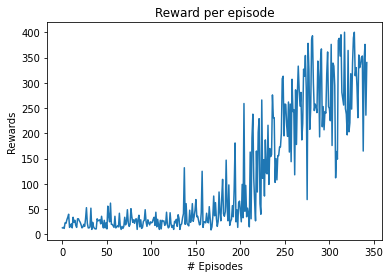

In [ ]:

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

# Checkpointing
checkpoint_path = set_checkpoint(env_name, directory= "PPO_preTrained", run_num_pretrained = 0)


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma,
                K_epochs, eps_clip, has_continuous_action_space, action_std)




# printing and logging variables
current_reward = 0
current_episode = 0
reward_list = []


time_step = 0
i_episode = 0


# training loop
while time_step <= max_timesteps:

    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_episodes+1):

        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step += 1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()
        # save model weights
        if time_step % save_model_freq == 0:
            ppo_agent.save(checkpoint_path)


        # break; if the episode is over
        if done:
            reward_list.append(current_ep_reward)

            break

    current_reward += current_ep_reward
    current_episode += 1

    i_episode += 1
plot_result(reward_list)
env.close()

# CartPole-v1 Testing


In [ ]:
# Hyperparameters
env_name = "CartPole-v1"
has_continuous_action_space = False
max_ep_len = 400
action_std = None


total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

loading network from : PPO_preTrained/CartPole-v1/PPO_CartPole-v1_0_0.pth
--------------------------------------------------------------------------------------------


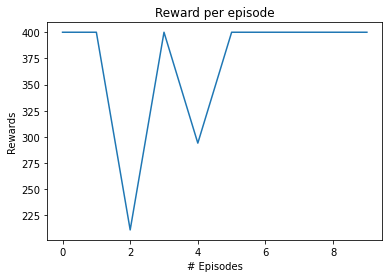

In [ ]:
env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



reward_list = []

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward

        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    reward_list.append(ep_reward)
    ep_reward = 0

env.close()

plot_result(reward_list)







# LunarLander-v2 Training

In [ ]:
# environment hyperparameters 

env_name = "LunarLander-v2"
has_continuous_action_space = False

max_ep_len = 400                   
max_training_timesteps = int(1e5)   

print_freq = max_ep_len * 4     
log_freq = max_ep_len * 2      
save_model_freq = int(2e4)     

action_std = None


# PPO hyperparameters 

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)


training environment name : LunarLander-v2
save checkpoint path : PPO_preTrained/LunarLander-v2/PPO_LunarLander-v2_0_0.pth


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


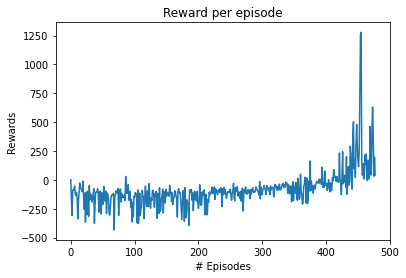

In [ ]:
print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# Checkpointing
checkpoint_path = set_checkpoint(env_name, directory= "PPO_preTrained", run_num_pretrained = 0)

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

print("============================================================================================")




# printing and logging variables
current_reward = 0
current_episode = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0
reward_list = []


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()
           
        # save model weights
        if time_step % save_model_freq == 0:
            ppo_agent.save(checkpoint_path)
            
        # break; if the episode is over
        if done:
            reward_list.append(current_reward)
            current_reward = 0
            break

    current_reward += current_ep_reward
    current_episode += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1

plot_result(reward_list)
env.close()

# Lunar Lander Testing

In [ ]:
# Hyperparameters
has_continuous_action_space = False
max_ep_len = 300
action_std = None

total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic


loading network from : PPO_preTrained/LunarLander-v2/PPO_LunarLander-v2_0_0.pth
--------------------------------------------------------------------------------------------


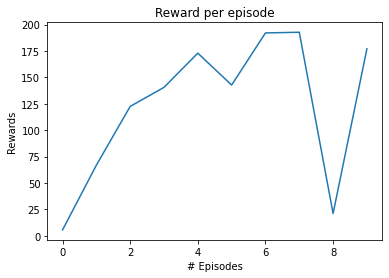

In [ ]:
env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0
reward_list = []

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    reward_list.append(ep_reward)
    ep_reward = 0

plot_result(reward_list)
env.close()

# Bipedal Walker Training

In [ ]:
# Environment Hyperparameters
env_name = "BipedalWalker-v2"
has_continuous_action_space = True

max_ep_len = 4000                   
max_training_timesteps = int(1e6)   

print_freq = max_ep_len * 4     
log_freq = max_ep_len * 2      
save_model_freq = int(2e4)     

# PPO Hyperparameters
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)


action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)


training environment name : BipedalWalker-v2
Box(4,)
save checkpoint path : PPO_preTrained/BipedalWalker-v2/PPO_BipedalWalker-v2_0_0.pth
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.55
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.5
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.45
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.4
------------------------------------------

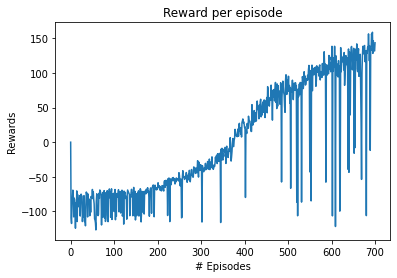

In [ ]:

print("training environment name : " + env_name)
env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    print(env.action_space)
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# Checkpointing
checkpoint_path = set_checkpoint(env_name, directory= "PPO_preTrained", run_num_pretrained = 0)


# printing and logging variables
current_reward = 0
current_episode = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0
reward_list = []

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)
          
        # save model weights
        if time_step % save_model_freq == 0:
            ppo_agent.save(checkpoint_path)
            
        # break; if the episode is over
        if done:
            reward_list.append(current_reward)
            current_reward = 0
            break

    current_reward += current_ep_reward
    current_episode += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1

plot_result(reward_list)
env.close()

In [ ]:
# Hyperparameters 



env_name = "BipedalWalker-v2"
has_continuous_action_space = True
max_ep_len = 1500           # max timesteps in one episode
action_std = 0.1            # set same std for action distribution which was used while saving



total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic


loading network from : PPO_preTrained/BipedalWalker-v2/PPO_BipedalWalker-v2_0_0.pth
--------------------------------------------------------------------------------------------


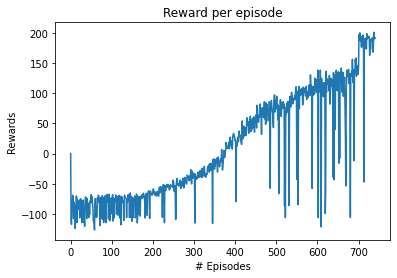

In [ ]:
env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    reward_list.append(ep_reward)
    ep_reward = 0

env.close()
plot_result(reward_list)